In [1]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import matplotlib.pyplot as plt

# 20대 마트/슈퍼/편의점 이용 데이터 연관분석

## 1. 데이터파일 준비

In [3]:
df_demo = pd.read_csv('data/LPOINT_BIG_COMP_01_DEMO.csv') # 고객정보
df_pdde = pd.read_csv('data/LPOINT_BIG_COMP_02_PDDE.csv', parse_dates = [6]) # 구매정보
df_copu = pd.read_csv('data/LPOINT_BIG_COMP_03_COP_U.csv', parse_dates = [5, 6]) # 유통사 이용 정보 (B01 ~ E00)
df_pd = pd.read_csv('data/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 정보

df_pdde['weekday'] = df_pdde['de_dt'].dt.weekday

DF = pd.merge(df_pdde, df_demo, on = 'cust')
DF = pd.merge(DF, df_pd, on = 'pd_c')
DF = DF.loc[(DF['ages'] == '20대')&(DF['cop_c'].apply(lambda x: x in ['A02', 'A03', 'A04']))]
print(DF.shape)
DF.head()

C:\Users\Eugene\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(196262, 17)


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,weekday,ma_fem_dv,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm
654,M496844384,A02191496496,1,A02,A020053,PD0290,2021-05-08,17,39000.0,1,5,여성,20대,Z17,남성티셔츠,남성의류,남성의류상의
2574,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,20000.0,2,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
2575,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,9000.0,9,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
2576,M748140584,A02262444001,1,A02,A020080,PD0290,2021-01-08,17,900.0,9,4,남성,20대,Z11,남성티셔츠,남성의류,남성의류상의
3166,M395590139,A02064243742,1,A02,A020012,PD0290,2021-02-01,11,600.0,6,0,여성,20대,Z17,남성티셔츠,남성의류,남성의류상의


# 함수 정의

In [4]:
def encode_units(x):
    if x >= 1: return 1
    else: return 0

In [5]:
# 데이터프레임 생성
def create_df(df, pd_dv = 'pd_nm'):
    df = df[['rct_no', pd_dv, 'buy_ct']]
    df = df.groupby(['rct_no', pd_dv])['buy_ct'].sum()
    df = df.unstack()
    df = df.applymap(encode_units)
    print('df shape:', df.shape)
    return df

In [6]:
# 지지도 분포 확인
def s_histogram(df, bins = 10):
    freq = df.sum(axis=0).to_frame('Frequency')
    freq_sort = freq.sort_values('Frequency', ascending=False)
    freq_sort = freq_sort[freq_sort['Frequency'] >1]

    freq_sort['Support'] = freq_sort['Frequency'] / len(df)

    freq_sort['Support'].hist(bins = bins)
    plt.show()

In [7]:
# 연관규칙 생성
def create_rule(df, min_support = 0.1, min_confidence = 0.2, plus = True):
    freq_items = apriori(df, min_support = min_support, use_colnames=True)
    rules = association_rules(freq_items, metric='confidence', min_threshold = min_confidence)
    print('규칙 개수:', len(rules))
    if plus:
        rules_sort = rules[rules['lift']>1].sort_values(by='confidence', ascending=False)
        print('양의 관계가 있는 규칙 개수:', len(rules_sort))
    else:
        rules_sort = rules[rules['lift']<1].sort_values(by='confidence', ascending=False)
        print('음의 관계가 있는 규칙 개수:', len(rules_sort))
    return rules_sort

In [8]:
# 조건구 규칙
def ante(df, item):
    return df[df['antecedents'].apply(lambda x: item in x)]

In [9]:
# 결론구 규칙
def cons(df, item):
    return df[df['consequents'].apply(lambda x: item in x)]

# 1. 식품을 구매한 장바구니 한정
## 01. 상품만 아이템으로 넣기
### a) 중분류

In [10]:
# 중분류
foods = ['건강식품', '건해산물', '과일', '과자', '냉동식품', '냉장식품', '대용식', '병통조림', '수산물', '주류', '채소'
         , '축산물', '커피/차', '양곡', '유제품', '음료', '조리식품', '조미료']
df_food = DF.loc[DF['clac_hlv_nm'].apply(lambda x: x in foods)]

### 탐색적 데이터 분석

In [31]:
df = create_df(df_food, 'clac_mcls_nm')

df shape: (41180, 113)


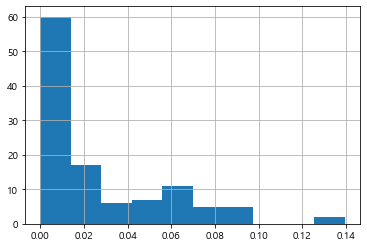

In [32]:
s_histogram(df) # 각 상품 지지도가 0.02 미만에서 높음

### 연관규칙 생성

In [33]:
rules = create_rule(df, 0.01)
rules

규칙 개수: 68
양의 관계가 있는 규칙 개수: 68


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(즉석음료류),(아이스크림),0.019014,0.056629,0.012385,0.651341,11.501811,0.011308,2.705711
66,"(열매채소, 버섯류)",(잎채소),0.016561,0.078849,0.010272,0.620235,7.866111,0.008966,2.425579
63,"(열매채소, 두부/콩나물류)",(잎채소),0.018893,0.078849,0.010369,0.548843,6.960691,0.008879,2.041754
33,(버섯류),(잎채소),0.049150,0.078849,0.024089,0.490119,6.215917,0.020214,1.806599
62,"(잎채소, 두부/콩나물류)",(열매채소),0.022244,0.057552,0.010369,0.466157,8.099727,0.009089,1.765403
...,...,...,...,...,...,...,...,...,...
45,(양채류),(수입과일),0.061195,0.066829,0.012676,0.207143,3.099616,0.008586,1.176973
46,(탄산음료),(스낵류),0.125935,0.139412,0.025595,0.203239,1.457830,0.008038,1.080108
11,(냉동간편식),(잎채소),0.057139,0.078849,0.011583,0.202720,2.570991,0.007078,1.155367
35,(봉지라면),(탄산음료),0.074162,0.125935,0.014983,0.202030,1.604242,0.005643,1.095361


### 규칙 확인

In [24]:
# 신뢰도 상위 20개 규칙
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(즉석음료류),(아이스크림),0.019014,0.056629,0.012385,0.651341,11.501811,0.011308,2.705711
65,"(열매채소, 버섯류)",(잎채소),0.016561,0.078849,0.010272,0.620235,7.866111,0.008966,2.425579
61,"(두부/콩나물류, 열매채소)",(잎채소),0.018893,0.078849,0.010369,0.548843,6.960691,0.008879,2.041754
33,(버섯류),(잎채소),0.049150,0.078849,0.024089,0.490119,6.215917,0.020214,1.806599
62,"(두부/콩나물류, 잎채소)",(열매채소),0.022244,0.057552,0.010369,0.466157,8.099727,0.009089,1.765403
54,(열매채소),(잎채소),0.057552,0.078849,0.025983,0.451477,5.725844,0.021446,1.679329
58,(장류),(잎채소),0.024089,0.078849,0.010345,0.429435,5.446305,0.008445,1.614456
66,"(잎채소, 버섯류)",(열매채소),0.024089,0.057552,0.010272,0.426411,7.409121,0.008886,1.643072
25,(소주),(맥주),0.056217,0.091501,0.022535,0.400864,4.380992,0.017391,1.516349
63,"(열매채소, 잎채소)",(두부/콩나물류),0.025983,0.067023,0.010369,0.399065,5.954172,0.008628,1.552544


__A 집합일 때 B 집합이 유의미하게 발생합니다.__
- {즉석음료류} > {아이스크림}
- {버섯류, 열매채소} > {잎채소}
- {열매채소, 두부/콩나물류} > {잎채소}

In [22]:
# 봉지리면이 조건구에 있는 규칙
ante(rules, '봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
34,(봉지라면),(스낵류),0.074162,0.139412,0.019645,0.264898,1.900108,0.009306,1.170706
35,(봉지라면),(탄산음료),0.074162,0.125935,0.014983,0.202030,1.604242,0.005643,1.095361


In [23]:
# 봉지리면이 결론구에 있는 규칙
cons(rules, '봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(냉동간편식),(봉지라면),0.057139,0.074162,0.012336,0.215895,2.911113,0.008099,1.180757


### b) 소분류

In [27]:
df_pdnm = create_df(df_food, 'pd_nm')

df shape: (41180, 618)


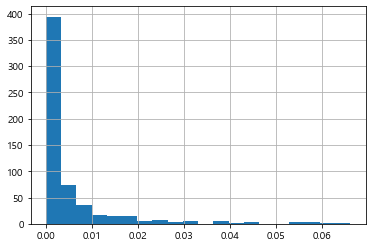

In [29]:
s_histogram(df_pdnm, bins = 20) #지지도가 0.005 미만에 분포

In [31]:
rules_pd = create_rule(df_pd, 0.005, 0.2)

규칙 개수: 20
양의 관계가 있는 규칙 개수: 20


In [32]:
rules_pd

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(파우치/즉석음료),(얼음),0.019014,0.026056,0.012263,0.644955,24.752339,0.011768,2.743158
16,(얼음),(파우치/즉석음료),0.026056,0.019014,0.012263,0.470643,24.752339,0.011768,1.853165
12,(애호박),(두부류),0.013866,0.046187,0.005828,0.420315,9.100201,0.005188,1.645399
13,(콩나물),(두부류),0.014959,0.046187,0.005318,0.355519,7.697315,0.004627,1.479971
6,(비빔봉지라면),(국물봉지라면),0.032030,0.053497,0.011365,0.354814,6.632433,0.009651,1.467024
19,(일반시리얼),(일반우유),0.016003,0.063987,0.005440,0.339909,5.312125,0.004416,1.418005
10,(일반소주),(국산맥주),0.053473,0.059155,0.017533,0.327884,5.542797,0.014370,1.399825
14,(팽이버섯류),(두부류),0.016999,0.046187,0.005148,0.302857,6.557128,0.004363,1.368174
11,(국산맥주),(일반소주),0.059155,0.053473,0.017533,0.296388,5.542797,0.014370,1.345240
17,(옥수수스낵),(일반스낵),0.043201,0.066246,0.012627,0.292299,4.412344,0.009766,1.319419


- 음료에 파우치가 파우치에 담긴 커피/음료 같아요
- 애호박 → 두부류 = 찌개요리
- 결과가 너무 당연해서 지지도가 많이 낮아도 되는 걸 알았습니다 ㅎ

## 02. 기타 속성 포함 - 소분류

### 오프라인 구매만

df shape: (6841, 478)


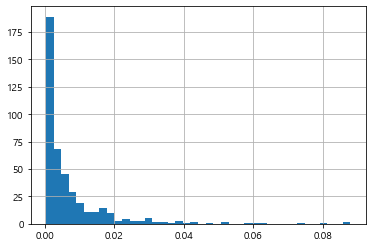

In [60]:
off_df = df_food[(df_food['cop_c'] == 'A03') & (df_food['chnl_dv'] == 1)]
off_ARM = create_df(off_df)
s_histogram(off_ARM, bins = 40)

In [61]:
off_rules = create_rule(off_ARM, 0.001)
off_rules

규칙 개수: 2691
양의 관계가 있는 규칙 개수: 2691


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1901,"(과일음료, 새송이버섯류, 떠먹는요구르트, 비빔봉지라면)",(샐러드류),0.001316,0.048385,0.001316,1.0,20.667674,0.001252,inf
904,"(비빔봉지라면, 떠먹는요구르트, 새송이버섯류)",(과일음료),0.001316,0.039614,0.001316,1.0,25.243542,0.001263,inf
1538,"(아보카도, 샐러드류, 옥수수스낵)",(새송이버섯류),0.001023,0.023388,0.001023,1.0,42.756250,0.000999,inf
724,"(아보카도, 옥수수스낵)",(샐러드류),0.001023,0.048385,0.001023,1.0,20.667674,0.000974,inf
2175,"(샐러드류, 새송이버섯류, 떠먹는요구르트, 사이다)",(바나나),0.001169,0.041661,0.001169,1.0,24.003509,0.001121,inf
...,...,...,...,...,...,...,...,...,...
154,"(쿠키, 감자스낵)",(국산맥주),0.005116,0.087999,0.001023,0.2,2.272757,0.000573,1.140001
519,"(일반계란, 두부류)",(일반스낵),0.008771,0.086537,0.001754,0.2,2.311149,0.000995,1.141829
594,"(일반스낵, 크래커)",(떠먹는요구르트),0.007309,0.052478,0.001462,0.2,3.811142,0.001078,1.184403
1159,"(떠먹는요구르트, 바나나)","(새송이버섯류, 국물용기라면)",0.007309,0.002924,0.001462,0.2,68.410000,0.001440,1.246346


In [72]:
off_rules.loc[(off_rules['conviction'] != float('inf')) & (off_rules['antecedents'].apply(lambda x: '떠먹는요구르트' in x))].head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
936,"(과일음료, 떠먹는요구르트, 새송이버섯류)",(샐러드류),0.003801,0.048385,0.003654,0.961538,19.872763,0.003471,24.741997
866,"(과일음료, 떠먹는요구르트, 바나나)",(샐러드류),0.003654,0.048385,0.003508,0.960000,19.840967,0.003331,23.790382
1744,"(과일음료, 새송이버섯류, 떠먹는요구르트, 바나나)",(샐러드류),0.003216,0.048385,0.003070,0.954545,19.728234,0.002914,20.935536
1399,"(떠먹는요구르트, 일반계란, 새송이버섯류)",(샐러드류),0.002777,0.048385,0.002631,0.947368,19.579901,0.002497,18.080690
2250,"(새송이버섯류, 일반계란, 떠먹는요구르트, 바나나)",(샐러드류),0.002193,0.048385,0.002046,0.933333,19.289829,0.001940,14.274229
1960,"(과일음료, 샐러드류, 떠먹는요구르트, 일반계란)",(새송이버섯류),0.002193,0.023388,0.002046,0.933333,39.905833,0.001995,14.649174
951,"(과일음료, 떠먹는요구르트, 일반계란)",(새송이버섯류),0.002193,0.023388,0.002046,0.933333,39.905833,0.001995,14.649174
1966,"(과일음료, 떠먹는요구르트, 일반계란)","(샐러드류, 새송이버섯류)",0.002193,0.006870,0.002046,0.933333,135.849645,0.002031,14.896945
2249,"(샐러드류, 떠먹는요구르트, 일반계란, 바나나)",(새송이버섯류),0.002193,0.023388,0.002046,0.933333,39.905833,0.001995,14.649174
1787,"(과일음료, 떠먹는요구르트, 일반계란, 바나나)",(새송이버섯류),0.001900,0.023388,0.001754,0.923077,39.467308,0.001710,12.695951


In [74]:
off_rules.loc[(off_rules['conviction'] != float('inf')) & (off_rules['antecedents'].apply(lambda x: '사이다' in x))].head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1277,"(떠먹는요구르트, 바나나, 사이다)",(샐러드류),0.001608,0.048385,0.001462,0.909091,18.788794,0.001384,10.467768
1460,"(샐러드류, 새송이버섯류, 사이다)",(바나나),0.001608,0.041661,0.001462,0.909091,21.821372,0.001395,10.541734
1275,"(샐러드류, 떠먹는요구르트, 사이다)",(바나나),0.001608,0.041661,0.001462,0.909091,21.821372,0.001395,10.541734
1730,"(과일음료, 샐러드류, 사이다)","(떠먹는요구르트, 바나나)",0.001316,0.007309,0.001169,0.888889,121.617778,0.001160,8.934220
1024,"(과일음료, 샐러드류, 사이다)",(바나나),0.001316,0.041661,0.001169,0.888889,21.336452,0.001115,8.625055
1731,"(과일음료, 떠먹는요구르트, 사이다)","(샐러드류, 바나나)",0.001316,0.008040,0.001169,0.888889,110.561616,0.001159,8.927642
1015,"(과일음료, 새송이버섯류, 사이다)",(바나나),0.001316,0.041661,0.001169,0.888889,21.336452,0.001115,8.625055
1016,"(과일음료, 바나나, 사이다)",(새송이버섯류),0.001316,0.023388,0.001169,0.888889,38.005556,0.001139,8.789504
1025,"(과일음료, 바나나, 사이다)",(샐러드류),0.001316,0.048385,0.001169,0.888889,18.371266,0.001106,8.564537
1727,"(과일음료, 바나나, 사이다)","(샐러드류, 떠먹는요구르트)",0.001316,0.008624,0.001169,0.888889,103.065913,0.001158,8.922380


전체적으로 __{과일음료, 떠먹는요구르트, 사이다, 샐러드류, 바나나, 새송이버섯류}__ 조합으로 많이 사는 것 같아요.
- (과일음료, 떠먹는요구르트, 사이다) → (샐러드류)
- (과일음료, 떠먹는요구르트, 사이다) → (바나나)

### 남성 구매 데이터만

In [50]:
man_df = df_food[(df_food['cop_c'] == 'A04') & (df_food['ma_fem_dv'] == '남성')]
man_ARM = create_df(man_df)

df shape: (7170, 182)


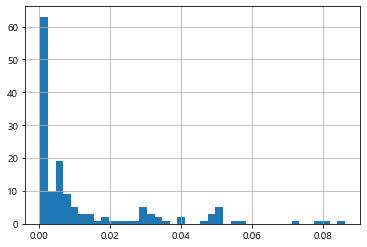

In [53]:
s_histogram(man_ARM, bins = 40)

In [54]:
man_rules = create_rule(man_ARM, 0.005)

규칙 개수: 11
양의 관계가 있는 규칙 개수: 11


In [55]:
man_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(파우치/즉석음료),(얼음),0.046025,0.049930,0.031939,0.693939,13.898172,0.029641,3.104188
8,(얼음),(파우치/즉석음료),0.049930,0.046025,0.031939,0.639665,13.898172,0.029641,2.647465
0,(일반빵),(가공우유),0.029847,0.086053,0.008926,0.299065,3.475363,0.006358,1.303898
4,(수입맥주),(국산맥주),0.032775,0.049372,0.009763,0.297872,6.033177,0.008145,1.353924
1,(김밥),(국물용기라면),0.040865,0.077685,0.009902,0.242321,3.119282,0.006728,1.217290
7,(햄버거),(샌드위치),0.028312,0.039052,0.006695,0.236453,6.054891,0.005589,1.258532
6,(국산맥주),(일반소주),0.049372,0.051604,0.011158,0.225989,4.379295,0.008610,1.225300
3,(비빔용기라면),(국물용기라면),0.026220,0.077685,0.005718,0.218085,2.807307,0.003681,1.179560
5,(일반소주),(국산맥주),0.051604,0.049372,0.011158,0.216216,4.379295,0.008610,1.212870
10,(일반스낵),(옥수수스낵),0.030265,0.035007,0.006416,0.211982,6.055410,0.005356,1.224582


- 남성 구매에선 샐러드류, 떠먹는요구르트 같은게 전혀 없음

## 03. 간편식만 아이템으로 포함

In [35]:
hmr = ['건면', '봉지라면', '레토르트', '용기라면', '시리얼', '분말조리식', '파스타류', '비빔봉지라면', '국물봉지라면', '즉석밥'
       , '국물용기라면', '즉석카레짜장', '국수', '비빔용기라면', '즉석덮밥류' '즉석컵밥' '즉석국/찌개', '일반시리얼', '즉석스프'
       , '즉석죽', '즉석누룽지', '기타레토르트', '분말카레짜장', '냉면', '즉석면류', '건우동', '기능성시리얼', '기타건면', '냉장간편식'
       , '포장반찬', '기타냉장간편식', '김밥재료세트', '절임반찬', '냉장치킨족발류', '볶음반찬', '냉장간편떡볶이', '김치류', '냉장국탕류'
       , '조림반찬', '무침반찬', '젓갈', '냉장밥/죽', '냉장안주', '냉동간편식', '냉동만두', '기타냉동간편식', '냉동튀김', '냉동밥'
       , '냉동간편식세트', '냉동피자', '냉동떡볶이', '냉동국탕류', '냉동부침', '냉장조리', '즉석반찬', '온장조리', '초밥류', '삼각김밥'
       , '기타냉장조리', '즉석국탕', '순대', '기타온장조리', '훈제/로스트', '김밥', '샌드위치', '샐러드', '튀김류', '즉석젓갈류'
       , '즉석김치류', '피자', '도시락', '치킨류', '롤', '온장조리원부재료', '꼬치류', '즉석반찬원부재료', '족발', '냉장조리원부재료'
       , '햄버거', '즉석어묵', '농산물병통조림', '수산물통조림', '축산물통조림', '병통조림선물세트', '채소병통조림', '과일병통조림'
       , '참치통조림', '기타축산통조림', '통조림혼합세트', '햄통조림세트', '기타수산통조림', '햄통조림', '참치통조림세트', '닭고기통조림'
       , '골뱅이통조림', '꽁치고등어통조림']

In [47]:
df_hmr_mcls = DF.loc[DF['clac_mcls_nm'].apply(lambda x: x in hmr)] # 중분류 데이터
df_hmr_pdnm = DF.loc[DF['pd_nm'].apply(lambda x: x in hmr)] # 소분류 데이터

### a) 중분류

df shape: (15439, 16)


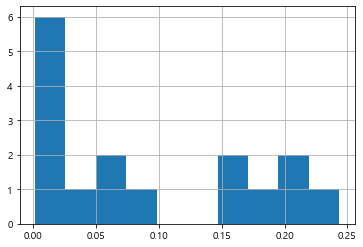

In [37]:
arm_hmr_mcls = create_df(df_hmr_mcls, 'clac_mcls_nm')
s_histogram(arm_hmr_mcls)

In [40]:
rules_hmr_mcls = create_rule(arm_hmr_mcls, 0.002)
rules_hmr_mcls

규칙 개수: 80
양의 관계가 있는 규칙 개수: 77


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
75,"(레토르트, 포장반찬, 냉동간편식)",(봉지라면),0.004275,0.197811,0.002267,0.530303,2.680861,0.001421,1.707887
79,"(봉지라면, 냉장간편식, 포장반찬)",(레토르트),0.004858,0.157523,0.002267,0.466667,2.962527,0.001502,1.579644
39,"(수산물통조림, 냉동간편식)",(봉지라면),0.005246,0.197811,0.002397,0.456790,2.309228,0.001359,1.476758
74,"(봉지라면, 포장반찬, 냉동간편식)",(레토르트),0.005311,0.157523,0.002267,0.426829,2.709629,0.001430,1.469853
78,"(포장반찬, 레토르트, 냉장간편식)",(봉지라면),0.005700,0.197811,0.002267,0.397727,2.010646,0.001139,1.331937
...,...,...,...,...,...,...,...,...,...
36,"(레토르트, 포장반찬)",(냉동간편식),0.020986,0.152406,0.004275,0.203704,1.336584,0.001077,1.064420
8,(농산물병통조림),(봉지라면),0.017229,0.197811,0.003498,0.203008,1.026271,0.000090,1.006520
28,"(봉지라면, 냉동간편식)",(냉장간편식),0.032904,0.178833,0.006671,0.202756,1.133773,0.000787,1.030007
67,"(용기라면, 포장반찬)",(봉지라면),0.013472,0.197811,0.002720,0.201923,1.020789,0.000055,1.005153


In [42]:
create_rule(arm_hmr_mcls, 0.002, plus = False)

규칙 개수: 80
음의 관계가 있는 규칙 개수: 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(용기라면),(냉장조리),0.206101,0.243539,0.049096,0.238215,0.978138,-0.001097,0.993011
45,"(용기라면, 냉장간편식)",(냉장조리),0.019885,0.243539,0.004340,0.218241,0.896123,-0.000503,0.967640
6,(냉장조리),(용기라면),0.243539,0.206101,0.049096,0.201596,0.978138,-0.001097,0.994357


- 용기라면을 사면 냉장조리는 사지 않는 경향 (그 역도 성립)

In [43]:
# 봉지라면이 조건구에 있는 규칙
ante(rules_hmr_mcls, '봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
79,"(봉지라면, 냉장간편식, 포장반찬)",(레토르트),0.004858,0.157523,0.002267,0.466667,2.962527,0.001502,1.579644
74,"(봉지라면, 포장반찬, 냉동간편식)",(레토르트),0.005311,0.157523,0.002267,0.426829,2.709629,0.001430,1.469853
76,"(봉지라면, 레토르트, 냉장간편식)",(포장반찬),0.005959,0.093011,0.002267,0.380435,4.090204,0.001713,1.463912
62,"(봉지라면, 포장반찬)",(레토르트),0.020014,0.157523,0.007319,0.365696,2.321537,0.004166,1.328191
68,"(봉지라면, 레토르트, 냉장간편식)",(냉동간편식),0.005959,0.152406,0.002137,0.358696,2.353550,0.001229,1.321672
38,"(봉지라면, 수산물통조림)",(냉동간편식),0.006995,0.152406,0.002397,0.342593,2.247891,0.001330,1.289298
71,"(봉지라면, 냉장간편식, 냉동간편식)",(레토르트),0.006671,0.157523,0.002137,0.320388,2.033913,0.001087,1.239644
77,"(봉지라면, 레토르트, 포장반찬)",(냉장간편식),0.007319,0.178833,0.002267,0.309735,1.731978,0.000958,1.189640
72,"(봉지라면, 레토르트, 포장반찬)",(냉동간편식),0.007319,0.152406,0.002267,0.309735,2.032295,0.001152,1.227924
32,"(봉지라면, 레토르트)",(냉동간편식),0.031220,0.152406,0.009651,0.309129,2.028320,0.004893,1.226847


In [44]:
# 봉지라면이 결론구에 있는 규칙
cons(rules_hmr_mcls, '봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
75,"(레토르트, 포장반찬, 냉동간편식)",(봉지라면),0.004275,0.197811,0.002267,0.530303,2.680861,0.001421,1.707887
39,"(수산물통조림, 냉동간편식)",(봉지라면),0.005246,0.197811,0.002397,0.456790,2.309228,0.001359,1.476758
78,"(포장반찬, 레토르트, 냉장간편식)",(봉지라면),0.005700,0.197811,0.002267,0.397727,2.010646,0.001139,1.331937
43,"(포장반찬, 냉동간편식)",(봉지라면),0.014185,0.197811,0.005311,0.374429,1.892866,0.002505,1.282332
34,"(레토르트, 냉동간편식)",(봉지라면),0.025973,0.197811,0.009651,0.371571,1.878417,0.004513,1.276500
70,"(레토르트, 냉장간편식, 냉동간편식)",(봉지라면),0.005765,0.197811,0.002137,0.370787,1.874451,0.000997,1.274908
41,"(용기라면, 냉동간편식)",(봉지라면),0.014638,0.197811,0.005246,0.358407,1.811869,0.002351,1.250309
63,"(레토르트, 포장반찬)",(봉지라면),0.020986,0.197811,0.007319,0.348765,1.763127,0.003168,1.231798
23,"(건면, 레토르트)",(봉지라면),0.008615,0.197811,0.002915,0.338346,1.710452,0.001211,1.212400
13,(축산물통조림),(봉지라면),0.016581,0.197811,0.005570,0.335938,1.698277,0.002290,1.208003


\+ 지지도가 너무 높은 아이템 빼고 해보기

- 보고 싶은 아이템이 있으면 확인해보기

### b) 소분류

df shape: (14097, 77)


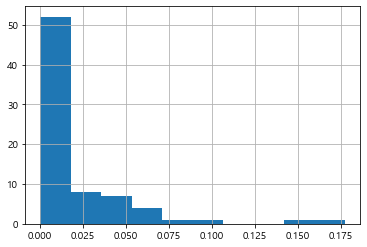

In [51]:
arm_hmr_pdnm = create_df(df_hmr_pdnm, 'pd_nm')
s_histogram(arm_hmr_pdnm)

In [52]:
rules_hmr_pdnm = create_rule(arm_hmr_pdnm, 0.001)
rules_hmr_pdnm

규칙 개수: 97
양의 관계가 있는 규칙 개수: 97


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
55,"(비빔봉지라면, 햄통조림)",(국물봉지라면),0.002057,0.156274,0.001277,0.620690,3.971794,0.000955,2.224368
19,"(비빔봉지라면, 국수)",(국물봉지라면),0.001773,0.156274,0.001064,0.600000,3.839401,0.000787,2.109314
94,"(냉동만두, 냉동튀김, 비빔봉지라면)",(국물봉지라면),0.002270,0.156274,0.001348,0.593750,3.799407,0.000993,2.076863
27,"(기타냉장간편식, 비빔봉지라면)",(국물봉지라면),0.002625,0.156274,0.001490,0.567568,3.631866,0.001080,1.951115
...,...,...,...,...,...,...,...,...,...
0,(국수),(국물봉지라면),0.013336,0.156274,0.002767,0.207447,1.327452,0.000682,1.064567
11,(김치류),(즉석밥),0.050862,0.066823,0.010499,0.206416,3.089003,0.007100,1.175902
9,(삼각김밥),(국물용기라면),0.075690,0.177130,0.015535,0.205248,1.158745,0.002128,1.035380
95,"(냉동만두, 냉동튀김)","(국물봉지라면, 비빔봉지라면)",0.006597,0.033199,0.001348,0.204301,6.153915,0.001129,1.215034


In [53]:
# 국물봉지라면이 조건구에 있는 규칙
ante(rules_hmr_pdnm, '국물봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
91,"(국물봉지라면, 냉동만두, 냉동튀김)",(비빔봉지라면),0.002696,0.093566,0.001348,0.500000,5.343821,0.001096,1.812868
44,"(국물봉지라면, 냉동튀김)",(비빔봉지라면),0.009009,0.093566,0.003618,0.401575,4.291888,0.002775,1.514699
48,"(국물봉지라면, 일반시리얼)",(비빔봉지라면),0.006810,0.093566,0.002696,0.395833,4.230525,0.002058,1.500305
32,"(김치류, 국물봉지라면)",(즉석밥),0.008796,0.066823,0.003476,0.395161,5.913576,0.002888,1.542853
17,"(비빔용기라면, 국물봉지라면)",(국물용기라면),0.006384,0.177130,0.002483,0.388889,2.195501,0.001352,1.346515
18,"(국물봉지라면, 국수)",(비빔봉지라면),0.002767,0.093566,0.001064,0.384615,4.110632,0.000805,1.472955
22,"(국물봉지라면, 기타냉동간편식)",(냉동튀김),0.004327,0.045471,0.001632,0.377049,8.292141,0.001435,1.532271
93,"(국물봉지라면, 냉동튀김, 비빔봉지라면)",(냉동만두),0.003618,0.055757,0.001348,0.372549,6.681709,0.001146,1.504888
54,"(국물봉지라면, 햄통조림)",(비빔봉지라면),0.003476,0.093566,0.001277,0.367347,3.926073,0.000952,1.432751


In [54]:
# 국물봉지라면이 결론구에 있는 규칙
cons(rules_hmr_pdnm, '국물봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
55,"(비빔봉지라면, 햄통조림)",(국물봉지라면),0.002057,0.156274,0.001277,0.620690,3.971794,0.000955,2.224368
19,"(비빔봉지라면, 국수)",(국물봉지라면),0.001773,0.156274,0.001064,0.600000,3.839401,0.000787,2.109314
94,"(냉동만두, 냉동튀김, 비빔봉지라면)",(국물봉지라면),0.002270,0.156274,0.001348,0.593750,3.799407,0.000993,2.076863
27,"(기타냉장간편식, 비빔봉지라면)",(국물봉지라면),0.002625,0.156274,0.001490,0.567568,3.631866,0.001080,1.951115
45,"(냉동튀김, 비빔봉지라면)",(국물봉지라면),0.006455,0.156274,0.003618,0.560440,3.586254,0.002609,1.919476
49,"(일반시리얼, 비빔봉지라면)",(국물봉지라면),0.004895,0.156274,0.002696,0.550725,3.524088,0.001931,1.877970
39,"(즉석밥, 냉동만두)",(국물봉지라면),0.003121,0.156274,0.001702,0.545455,3.490364,0.001215,1.856196
38,"(냉동만두, 비빔봉지라면)",(국물봉지라면),0.008583,0.156274,0.004611,0.537190,3.437480,0.003270,1.823050
51,"(즉석밥, 비빔봉지라면)",(국물봉지라면),0.007023,0.156274,0.003689,0.525253,3.361092,0.002591,1.777209


In [55]:
# 즉석밥이 조건구에 있는 규칙
ante(rules_hmr_pdnm, '즉석밥')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
88,"(김치류, 즉석밥, 비빔봉지라면)",(국물봉지라면),0.001632,0.156274,0.001064,0.652174,4.173262,0.000809,2.425711
39,"(즉석밥, 냉동만두)",(국물봉지라면),0.003121,0.156274,0.001702,0.545455,3.490364,0.001215,1.856196
51,"(즉석밥, 비빔봉지라면)",(국물봉지라면),0.007023,0.156274,0.003689,0.525253,3.361092,0.002591,1.777209
75,"(비빔용기라면, 즉석밥)",(국물용기라면),0.003334,0.177130,0.001632,0.489362,2.762728,0.001041,1.611454
77,"(기타냉장간편식, 즉석밥)",(김치류),0.004469,0.050862,0.001986,0.444444,8.738261,0.001759,1.708449
85,"(즉석밥, 냉동튀김)",(비빔봉지라면),0.002554,0.093566,0.001135,0.444444,4.750063,0.000896,1.631581
81,"(비빔용기라면, 즉석밥)",(김치류),0.003334,0.050862,0.001277,0.382979,7.529778,0.001107,1.538258
56,"(비빔용기라면, 즉석밥)",(국물봉지라면),0.003334,0.156274,0.001135,0.340426,2.178383,0.000614,1.279197
33,"(김치류, 즉석밥)",(국물봉지라면),0.010499,0.156274,0.003476,0.331081,2.118588,0.001835,1.261327
28,"(기타냉장간편식, 즉석밥)",(국물봉지라면),0.004469,0.156274,0.001419,0.317460,2.031429,0.000720,1.236156


In [56]:
# 즉석밥이 결론구에 있는 규칙
cons(rules_hmr_pdnm, '즉석밥')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(김치류, 국물봉지라면, 비빔봉지라면)",(즉석밥),0.001986,0.066823,0.001064,0.535714,8.016947,0.000931,2.009920
76,"(김치류, 기타냉장간편식)",(즉석밥),0.004114,0.066823,0.001986,0.482759,7.224467,0.001711,1.804143
80,"(김치류, 비빔용기라면)",(즉석밥),0.003050,0.066823,0.001277,0.418605,6.264405,0.001073,1.605065
32,"(김치류, 국물봉지라면)",(즉석밥),0.008796,0.066823,0.003476,0.395161,5.913576,0.002888,1.542853
78,"(김치류, 비빔봉지라면)",(즉석밥),0.004398,0.066823,0.001632,0.370968,5.551520,0.001338,1.483513
59,"(국물용기라면, 기타냉장간편식)",(즉석밥),0.003476,0.066823,0.001277,0.367347,5.497335,0.001045,1.475022
69,"(김치류, 국물용기라면)",(즉석밥),0.008512,0.066823,0.002767,0.325000,4.863615,0.002198,1.382485
29,"(기타냉장간편식, 국물봉지라면)",(즉석밥),0.004824,0.066823,0.001419,0.294118,4.401461,0.001096,1.322001
90,"(김치류, 비빔봉지라면)","(국물봉지라면, 즉석밥)",0.004398,0.013194,0.001064,0.241935,18.336368,0.001006,1.301744
11,(김치류),(즉석밥),0.050862,0.066823,0.010499,0.206416,3.089003,0.007100,1.175902


# 2. 편의점

마트/슈퍼에서 장 볼때는 한 번에 먹는 식품만 사는 게 아닐 것 같아서 편의점 데이터만 따로 봤습니다.

In [58]:
conDF = df_food[df_food['cop_c'] == 'A04']

df shape: (16798, 210)


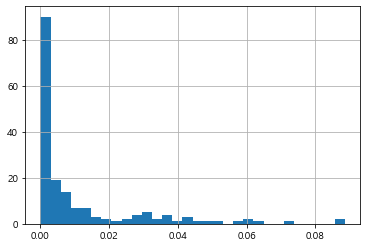

In [63]:
dfcon = create_df(conDF)
s_histogram(dfcon, 30)

In [65]:
rules_con = create_rule(dfcon, min_support = 0.001)

규칙 개수: 74
양의 관계가 있는 규칙 개수: 74


In [225]:
print('< 규칙에 있는 아이템 > \n')

itms = set()
def itemsin(x):
    global itms
    itms = itms|set(x)
rules_con['antecedents'].apply(itemsin)
rules_con['consequents'].apply(itemsin)
for i in itms:
    print(i, end = ', ')

< 규칙에 있는 아이템 > 

일반소주, 햄버거, 하드캔디, 파우치/즉석음료, 모나카, 감자스낵, 일반스낵, 튜브아이스크림, 탄산수, 국물용기라면, 오징어, 바아이스크림, 종합영양제, 김치류, 생수, 콘아이스크림, 국산맥주, 젤리, 가공우유, 숙취해소음료, 일반차음료, 쿠키, 삼각김밥, 냉동만두, 콜라, 김밥, 리큐르, 파이, 비타민/에너지음료, 옥수수스낵, 일반빵, 샌드위치, 얼음, 비빔용기라면, 기타전통과자, 국물봉지라면, 수입맥주, 

In [234]:
ante(rules_con, '모나카')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,(모나카),(바아이스크림),0.005834,0.014109,0.001369,0.234694,16.634547,0.001287,1.288231
15,(모나카),(콘아이스크림),0.005834,0.009823,0.001250,0.214286,21.815584,0.001193,1.260226


In [233]:
ante(rules_con, '비빔용기라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
46,"(비빔용기라면, 김밥)",(국물용기라면),0.003274,0.086677,0.001250,0.381818,4.405070,0.000966,1.477434
18,(비빔용기라면),(삼각김밥),0.030718,0.061079,0.006608,0.215116,3.521952,0.004732,1.196255
48,"(국물용기라면, 비빔용기라면)",(삼각김밥),0.006251,0.061079,0.001310,0.209524,3.430391,0.000928,1.187792
4,(비빔용기라면),(국물용기라면),0.030718,0.086677,0.006251,0.203488,2.347663,0.003588,1.146654
47,"(비빔용기라면, 국물용기라면)",(김밥),0.006251,0.038516,0.001250,0.200000,5.192581,0.001009,1.201854


In [66]:
ante(rules_con, '국물봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
41,"(국물봉지라면, 일반차음료)",(국산맥주),0.001191,0.050125,0.001012,0.850000,16.957601,0.000952,6.332500
42,"(국물봉지라면, 국산맥주)",(일반차음료),0.002322,0.056614,0.001012,0.435897,7.699480,0.000881,1.672366


In [68]:
ante(rules_con, '일반차음료')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
41,"(국물봉지라면, 일반차음료)",(국산맥주),0.001191,0.050125,0.001012,0.850000,16.957601,0.000952,6.332500
43,"(일반차음료, 국산맥주)",(국물봉지라면),0.003691,0.012799,0.001012,0.274194,21.422806,0.000965,1.360143


In [69]:
ante(rules_con, '국물용기라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,"(국물용기라면, 파우치/즉석음료)",(얼음),0.001845,0.052149,0.001012,0.548387,10.515761,0.000916,2.098813
50,"(국물용기라면, 얼음)",(파우치/즉석음료),0.002441,0.046196,0.001012,0.414634,8.975547,0.000899,1.629415
44,"(일반소주, 국물용기라면)",(국산맥주),0.003512,0.050125,0.001250,0.355932,7.100890,0.001074,1.474806
45,"(국물용기라면, 국산맥주)",(일반소주),0.004108,0.043934,0.001250,0.304348,6.927418,0.001070,1.374345
48,"(국물용기라면, 비빔용기라면)",(삼각김밥),0.006251,0.061079,0.001310,0.209524,3.430391,0.000928,1.187792
47,"(비빔용기라면, 국물용기라면)",(김밥),0.006251,0.038516,0.001250,0.200000,5.192581,0.001009,1.201854


- (국물봉지라면, 일반차음료) → (국산맥주)
- (숙취해소음료) → (종합영양제)
- (모나카) → (각종 아이스크림들)

# 슈퍼

In [73]:
superDF = df_food[df_food['cop_c'] == 'A03']

df shape: (7008, 490)


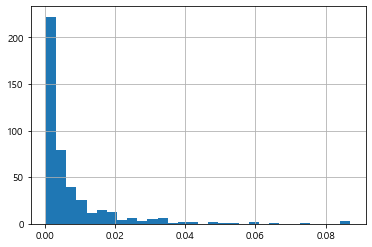

In [115]:
df_super = create_df(superDF, 'pd_nm')
s_histogram(df_super, 30)

In [105]:
rules_super = create_rule(df_super, min_support = 0.001)

규칙 개수: 1902
양의 관계가 있는 규칙 개수: 1902


In [16]:
itms = set()

rules_super['antecedents'].apply(itemsin)
rules_super['consequents'].apply(itemsin)
for i in itms:
    print(i, end = ', ')

NameError: name 'rules_super' is not defined

In [221]:
s = '베이컨'
display(ante(rules_super, s))
display(cons(rules_super, s))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
91,(베이컨),(일반우유),0.010845,0.087043,0.002283,0.210526,2.418637,0.001339,1.156412


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [227]:
ante(rules_super, '모나카')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
80,(모나카),(바아이스크림),0.00528,0.017266,0.001427,0.270270,15.653339,0.001336,1.346710
82,(모나카),(콘아이스크림),0.00528,0.018836,0.001142,0.216216,11.479115,0.001042,1.251830
81,(모나카),(컵아이스크림),0.00528,0.008562,0.001142,0.216216,25.254054,0.001096,1.264939


In [106]:
ante(rules_super, '국물봉지라면')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
301,"(국물봉지라면, 새송이버섯류)",(샐러드류),0.002997,0.047945,0.001712,0.571429,11.918367,0.001569,2.221461
300,"(국물봉지라면, 샐러드류)",(새송이버섯류),0.002997,0.023545,0.001712,0.571429,24.270130,0.001642,2.278396
304,"(국물봉지라면, 일반시리얼)",(일반우유),0.002283,0.087043,0.001142,0.500000,5.744262,0.000943,1.825913
298,"(국물봉지라면, 즉석밥)",(비빔봉지라면),0.002854,0.032249,0.001284,0.450000,13.953982,0.001192,1.759548
290,"(국물봉지라면, 샐러드류)",(떠먹는요구르트),0.002997,0.051227,0.001284,0.428571,8.366096,0.001131,1.660352
181,"(국물봉지라면, 바나나)",(과일음료),0.002854,0.039384,0.001142,0.400000,10.156522,0.001029,1.601027
292,"(국물봉지라면, 바나나)",(새송이버섯류),0.002854,0.023545,0.001142,0.400000,16.989091,0.001074,1.627426
295,"(국물봉지라면, 바나나)",(샐러드류),0.002854,0.047945,0.001142,0.400000,8.342857,0.001005,1.586758
285,"(일반소주, 국물봉지라면)",(국산맥주),0.004424,0.085902,0.001712,0.387097,4.506269,0.001332,1.491423
294,"(국물봉지라면, 샐러드류)",(바나나),0.002997,0.042237,0.001142,0.380952,9.019305,0.001015,1.547155


In [81]:
ante(rules_super, '즉석밥')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
299,"(즉석밥, 비빔봉지라면)",(국물봉지라면),0.001998,0.060360,0.001284,0.642857,10.650456,0.001164,2.630993
298,"(국물봉지라면, 즉석밥)",(비빔봉지라면),0.002854,0.032249,0.001284,0.450000,13.953982,0.001192,1.759548


In [82]:
ante(rules_super, '즉석죽')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
71,(즉석죽),(떠먹는요구르트),0.00585,0.051227,0.001284,0.219512,4.285074,0.000985,1.215615


In [133]:
ante(rules_super, '냉동밥')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
39,(냉동밥),(냉동만두),0.00528,0.016981,0.001142,0.216216,12.733136,0.001052,1.254197


- (국물봉지라면, 새송이버섯류) → (샐러드류)	/ (국물봉지라면, 샐러드류) → (새송이버섯류)
- (즉석죽) → (떠먹는요구르트)
- (냉동밥) → (냉동만두)
- (참치통조림) → (두부류)
- (블루베리) → (기능성우유)
- (냉동튀김, 양파) → (두부류)
- (과일잼) → (일반계란)
- (베이컨) → (일반우유)	

# 30대 편의점/슈퍼

In [13]:
DF30 = pd.merge(df_pdde, df_demo, on = 'cust')
DF30 = pd.merge(DF30, df_pd, on = 'pd_c')
DF30 = DF30[(DF30['ages'] == '30대')&(DF30['clac_hlv_nm'].apply(lambda x: (x in foods)&(x != '과자')))]

df_super30 = DF30[DF30['cop_c'] == 'A03']
df_con30 = DF30[DF30['cop_c'] == 'A04']

df shape: (36002, 522)


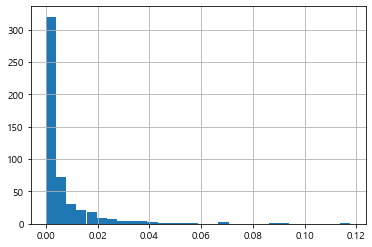

In [14]:
super30 = create_df(df_super30, 'pd_nm')
s_histogram(super30, 30)

In [15]:
rules_super30 = create_rule(super30, min_support = 0.005)
rules_super30

규칙 개수: 16
양의 관계가 있는 규칙 개수: 16


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(애호박),(두부류),0.027776,0.086384,0.010638,0.383000,4.433687,0.008239,1.480739
12,(일반시리얼),(일반우유),0.020388,0.117632,0.006889,0.337875,2.872294,0.004490,1.332629
4,(일반소주),(국산맥주),0.068635,0.091884,0.022165,0.322946,3.514724,0.015859,1.341276
2,(비빔봉지라면),(국물봉지라면),0.029359,0.068357,0.009305,0.316935,4.636442,0.007298,1.363915
9,(콩나물),(두부류),0.034470,0.086384,0.010805,0.313457,3.628641,0.007827,1.330748
13,(일반요구르트),(일반우유),0.052664,0.117632,0.015805,0.300105,2.551216,0.009610,1.260715
5,(느타리버섯류),(두부류),0.019054,0.086384,0.005639,0.295918,3.425612,0.003993,1.297599
0,(감자),(두부류),0.018777,0.086384,0.005389,0.286982,3.322166,0.003767,1.281337
10,(팽이버섯류),(두부류),0.022554,0.086384,0.006361,0.282020,3.264718,0.004412,1.272480
15,(햄),(일반우유),0.024415,0.117632,0.005972,0.244596,2.079327,0.003100,1.168074


In [171]:
ante(rules_super30, '햄')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,(햄),(일반우유),0.023554,0.113484,0.005761,0.244596,2.155334,0.003088,1.173565
36,(햄),(맛살),0.023554,0.017043,0.004743,0.201365,11.815324,0.004342,1.230797


df shape: (28375, 193)


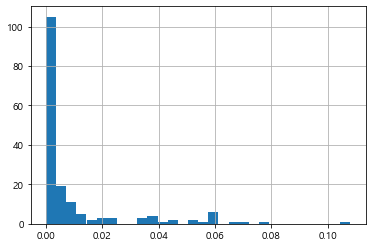

In [17]:
con30 = create_df(df_con30, 'pd_nm')
s_histogram(con30, 30)

In [19]:
rules_con30 = create_rule(con30, min_support = 0.001)
rules_con30

규칙 개수: 46
양의 관계가 있는 규칙 개수: 46


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
43,"(파우치/즉석음료, 일반차음료)",(얼음),0.001621,0.052476,0.001163,0.717391,13.670905,0.001078,3.352778
45,"(커피음료, 파우치/즉석음료)",(얼음),0.001586,0.052476,0.001128,0.711111,13.551228,0.001045,3.279892
31,"(가공우유, 파우치/즉석음료)",(얼음),0.002115,0.052476,0.001410,0.666667,12.704276,0.001299,2.842573
18,(리큐르),(수입맥주),0.005709,0.044229,0.003736,0.654321,14.793911,0.003483,2.764909
41,"(파우치/즉석음료, 생수)",(얼음),0.001833,0.052476,0.001128,0.615385,11.727024,0.001032,2.463563
26,(얼음),(파우치/즉석음료),0.052476,0.060863,0.029040,0.553392,9.092348,0.025846,2.102819
27,(파우치/즉석음료),(얼음),0.060863,0.052476,0.029040,0.477128,9.092348,0.025846,1.812153
39,"(콘아이스크림, 튜브아이스크림)",(바아이스크림),0.002714,0.023225,0.001269,0.467532,20.130855,0.001206,1.834432
42,"(얼음, 일반차음료)",(파우치/즉석음료),0.002537,0.060863,0.001163,0.458333,7.530520,0.001009,1.733791
3,(김치류),(국물용기라면),0.008176,0.075665,0.003630,0.443966,5.867500,0.003011,1.662370


- 30대 데이터가 많아서 한 번 해봤습니다.
- 30대는 아이 있는 사람들이 과자를 많이 사는 것 같아서 30대 미혼자만 뽑아서 하면 좋을 것 같은데 아이디어 있으면 얘기해주세요.
- 비교적 슈퍼보다 편의점 소비가 젊은 사람들같긴 하네요.

# 정리
## 눈여겨볼만한 것들
- (국물봉지라면, 일반차음료) → (국산맥주)
- (국물봉지라면, 새송이버섯류) → (샐러드류)	/ (국물봉지라면, 샐러드류) → (새송이버섯류)
- __(즉석죽) → (떠먹는요구르트)  --> 소화 안 될 때? 아침?__
- __(냉동밥) → (냉동만두)  --> 만두밥 맞는거같고, 진짜 간편식!__
- (참치통조림) → (두부류)
- (블루베리) → (기능성우유)
- (냉동튀김, 양파) → (두부류)
- (과일잼) → (일반계란)
- (베이컨) → (일반우유)
- (숙취해소음료) → (종합영양제)
- (모나카) → (각종 아이스크림들)

++
  
여자들이 __{과일음료, 떠먹는요구르트, 사이다, 샐러드류, 바나나, 새송이버섯류}__ 조합이 많음
- (과일음료, 떠먹는요구르트, 사이다) → (샐러드류)
- (과일음료, 떠먹는요구르트, 사이다) → (바나나)
--> 키위, 파인애플 말고는 과일맛 드레싱을 잘 안 팔아서 만들어먹는다!
--> 다이어트식은 아닌 것 같고(음료 때문에) 건강? 비건?